In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, ticker, rcParams
from matplotlib.colors import LogNorm
from scipy.optimize import newton
from astropy.io import fits
import scipy.constants as sc

In [64]:
beta = 1.25 # flaring exponent beta

# define radial grid in au
R = fits.open('/data/jhyl3/mcfost_files/run_30/data_disk_original/grid.fits.gz')[0].data[0,0,0]

# define orbital frequency
stellar_mass = 1 # in solar masses
Omega = (np.sqrt(sc.G * stellar_mass * 2e30) * 1.5e11**(-1.5)) * R**(-1.5)

# generate scale height with H = 11 au at 100 au
H = 9 * (R/100)**beta
H_R = H / R # aspect ratio

# neutral sound speed
c_s = Omega * H * 1.5e8 # in km/s

# fixed ionisation quantities
alpha_2 = 2.6e-13 # recombination coefficient in /cm3/s


M_disc = 1e-3 # DUST disc mass in Msun
sigma_ref_exp = lambda M_disc, Rref, Rin, Rout, Rc: M_disc * 100 / (2*np.pi * Rref * (1.5e13)**2 / 2e33 * Rc * (np.exp(-Rin/Rc) - np.exp(-Rout/Rc)))
sigma_ref_pl = lambda M_gas, Rref, Rin, Rout, gamma: M_gas * (2-gamma) / (2*np.pi * Rref**gamma * (Rout**(2-gamma) - Rin**(2-gamma))) * 2e33 / (1.5e13**2) # if just power law
# the tapered profile (with the exponential cutoff) gives a very different sigma_ref to just a power law

In [77]:
c_s[np.argmin(np.abs(R-100))]**2 * 2.34 / 8315 * 1e6 # temperature at 100 au, 2.34 is the mean molecular weight; matching WG17 20K at 100 au
sigma_ref_pl(0.03, 10, 2, 100, 2.25) # WG17 disc

113.7218086616085

Text(0.5, 1.0, 'Surface mass loss rates at 10 au')

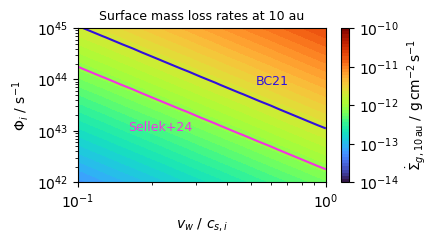

In [66]:
# parameter space exploration
N = 10
M = 20
phi_i_ls = np.logspace(42, 45, M)
c_si = 12.9 # ionised sound speed in km/s
R_g_cm = sc.G * stellar_mass * 2e30 / (c_si * 1e3)**2 * 1e2 # gravitational radius in cm
v_w_ls = np.logspace(-1, 0, N) * c_si
smlr_vw_ls = (3*phi_i_ls/(4*np.pi*alpha_2))**(0.5) * R_g_cm * (sc.m_p * 1e3) * (10 * 1.5e13)**(-2.5) # in g/cm3, evaluated at 10 au
sdot_grid = np.tile(smlr_vw_ls, (N,1)).T * np.tile(v_w_ls, (M,1)) * 1e5 # in g/cm2/s
rcParams["figure.figsize"] = (4,2)
fig, ax = plt.subplots()
sdot_plot = ax.contourf(v_w_ls/c_si, phi_i_ls, sdot_grid, levels=10**np.linspace(-14, -10, 50), norm=LogNorm(), cmap='turbo')
ax.contour(v_w_ls/c_si, phi_i_ls, sdot_grid, [2e-12], colors="#2F10DD")
ax.contour(v_w_ls/c_si, phi_i_ls, sdot_grid, [8e-13], colors="#F332E3")
ax.set_xscale('log')
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.set_yscale('log')
ax.text(5.2e-1, 8e43, 'BC21', c='#2F10DD', fontsize=9)
ax.text(1.6e-1, 1e43, 'Sellek+24', c="#F332E3", fontsize=9)
clb = fig.colorbar(sdot_plot, ax=ax, label=r'$\dot\Sigma_{g,10\,\mathrm{au}}$ / $\mathrm{g\,cm^{-2}\,s^{-1}}$', ticks=10**np.linspace(-14, -10, 5))
ax.set_xlabel(r'$v_w$ / $c_{s,i}$')
ax.set_ylabel(r'$\Phi_i$ / $\mathrm{s^{-1}}$')
ax.set_title(r'Surface mass loss rates at 10 au', fontsize=9)

surface mass loss rate at 10au: 8.26e-14 g/cm2/s
surface density at 10 au for 3.00e-02 Msun: 1.10e+02 g/cm2


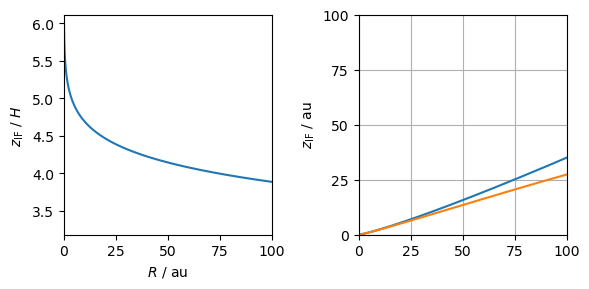

In [92]:
# varying ionisation quantities
phi_i = 10**(40.5) # ionising photon luminosity in /s
c_si = 12.9 # ionised sound speed in km/s
v_w = 0.8 * c_si # ionised wind speed in km/s
R_g_cm = sc.G * stellar_mass * 2e30 / (c_si * 1e3)**2 * 1e2 # gravitational radius in cm

# calculate dot sigma/v_w; this has units of density, if dominated by hydrogen ions
# for R>R_g
smlr_vw_g = (3*phi_i/(4*np.pi*alpha_2))**(0.5) * R_g_cm * (sc.m_p * 1e3) * (R * 1.5e13)**(-2.5) # in g/cm3
# for R<=R_g
smlr_vw_l = (3*phi_i/(4*np.pi*alpha_2))**(0.5) * (sc.m_p * 1e3) * (R * 1.5e13)**(-1.5) # in g/cm3

# calculate surface mass loss rate and print 10 au value
sdot = (smlr_vw_g * v_w * 1e5) # in g/cm2/s
print(f'surface mass loss rate at 10au: {sdot[np.argmin(np.abs(R-10))]:.2e} g/cm2/s')

rho_g_p = (c_si**2 + v_w**2)/(2*c_s**2) * smlr_vw_g * ( 1 + np.sqrt( 1 - ( 2*c_s*v_w / (c_si**2 + v_w**2 ) )**2 ) )
rho_l = (c_si**2 + v_w**2)/(2*c_s**2) * smlr_vw_l * ( 1 + np.sqrt( 1 - ( 2*c_s*v_w / (c_si**2 + v_w**2 ) )**2 ) )

sd = sigma_ref_pl(0.03, 10, 2, 100, 2.25) * (R/10)**(-2.25) # in g/cm2
rho0 = sd / (np.sqrt(2*np.pi) * (H * 1.5e13))
print(f'surface density at 10 au for {0.03:.2e} Msun: {sd[np.argmin(np.abs(R-10))]:.2e} g/cm2')

z_if = np.sqrt(2 * np.log(rho0 / rho_g_p)) # z<<R approximation
z_if_2 = np.sqrt(2 * np.log(rho0 / rho_l))
rcParams["figure.figsize"] = (6,3)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(R, z_if)
ax1.set_xlabel(r'$R$ / $\mathrm{au}$')
ax1.set_ylabel(r'$z_\mathrm{IF}$ / $H$')
ax2.plot(R, z_if * H)
ax2.plot(R, z_if_2 * H)
ax2.set_xticks([0, 25, 50, 75, 100])
ax2.set_yticks([0, 25, 50, 75, 100])
ax2.set_ylabel(r'$z_\mathrm{IF}$ / $\mathrm{au}$')
# ax2.axhline(15)
# ax2.axhline(35)
# ax2.axhline(65)
ax2.grid()
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
ax2.set_ylim(0,100)
plt.tight_layout()

Text(0, 0.5, '$\\mathrm{Ma}$')

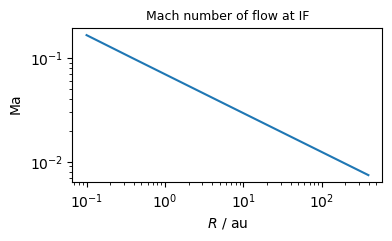

In [5]:
rcParams['figure.figsize'] = (4,2)
Ma = (sdot/rho_g_p/1e5) / c_s
plt.plot(R, Ma)
plt.xscale('log')
plt.yscale('log')
plt.title('Mach number of flow at IF', fontsize=9)
plt.xlabel(r'$R$ / $\mathrm{au}$')
plt.ylabel(r'$\mathrm{Ma}$')

Text(0.5, 1.0, 'IF height at 10 au, $M_\\mathrm{gas}=$3e-02 $M_\\odot$')

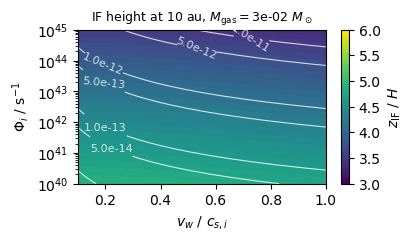

In [84]:
# explore parameter space
Rref = 10 # in au
N = 50
M = 30
v_w_ls = np.logspace(-1, 0, M) * c_si
v_w_grid = np.tile(v_w_ls, (N,1))
R_g_cm = sc.G * stellar_mass * 2e30 / (c_si * 1e3)**2 * 1e2 # gravitational radius in cm
Phi_ls = np.logspace(40, 45, N) # ionising photon luminosity in /s
smlr10_vw_ls = (3*Phi_ls/(4*np.pi*alpha_2))**(0.5) * R_g_cm * (sc.m_p * 1e3) * (Rref * 1.5e13)**(-2.5) # in g/cm3, evaluated at 10 au
smlr10_vw_grid = np.tile(smlr10_vw_ls, (M,1)).T
smlr10 = smlr10_vw_grid * (v_w_grid * 1e5) # in g/cm2/s
c_s10 = c_s[np.argmin(np.abs(R-Rref))] # sound speed at 10 au
rho_g_p = (c_si**2 + v_w_grid**2)/(2*c_s[np.argmin(np.abs(R-Rref))]**2) * smlr10_vw_grid * ( 1 + np.sqrt( 1 - ( 2*c_s10*v_w_grid / (c_si**2 + v_w_grid**2 ) )**2 ) )
M_gas = 0.03
sd = sigma_ref_pl(M_gas, 10, 2, 100, 2.25) * (R/10)**(-2.25) # in g/cm2
rho0 = sd / (np.sqrt(2*np.pi) * (H*1.5e13))
z_if = np.sqrt(2 * np.log(rho0[np.argmin(np.abs(R-Rref))] / rho_g_p))
rcParams["figure.figsize"] = (4,2)
if_plot = plt.contourf(v_w_ls/c_si, Phi_ls, z_if, levels=np.linspace(3,6,50), cmap='viridis')
smlr_plot = plt.contour(v_w_ls/c_si, Phi_ls, smlr10, levels=[1e-14, 5e-14, 1e-13, 5e-13, 1e-12, 5e-12, 1e-11], colors='white', alpha=0.8, linewidths=0.8)
# np.logspace(-14, -11, 6)
# plt.contour(v_w_ls/c_si, Phi_ls, smlr10, [2e-12], colors='white')
# plt.contour(v_w_ls/c_si, Phi_ls, smlr10, [8e-13], colors='blue')
# fmt = ticker.LogFormatterSciNotation()
plt.clabel(smlr_plot, fmt="%.1e", fontsize=8)
cbar = plt.colorbar(if_plot, ticks=np.linspace(3,6,7))
cbar.set_label(r'$z_\mathrm{IF}$ / $H$')
plt.yscale('log')
plt.ylabel(r'$\Phi_i$ / $\mathrm{s^{-1}}$')
plt.xlabel(r'$v_w$ / $c_{s,i}$')
plt.title(r'IF height at 10 au, $M_\mathrm{gas}=$'+f'{M_gas:.0e}'+r' $M_\odot$', fontsize=9)

/tmp/ipykernel_3952941/2471688110.py:15: RuntimeWarning: invalid value encountered in sqrt
  z_if = np.sqrt(2 * np.log(rho0[np.argmin(np.abs(R-Rref))] / rho_g_p))


Text(0, 0.5, '$\\dot\\Sigma_{g,10\\,\\mathrm{au}}$ / $\\mathrm{g\\,cm^{-2}\\,s^{-1}}$')

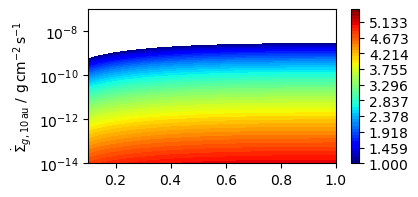

In [ ]:
# explore parameter space
Rref = 10
N = 50
M = 30
c_si = 12.9 # ionised sound speed in km/s
R_g_cm = sc.G * stellar_mass * 2e30 / (c_si * 1e3)**2 * 1e2 # gravitational radius in cm
v_w_ls = np.logspace(-1, 0, M) * c_si
v_w_grid = np.tile(v_w_ls, (N,1))
smlr10_ls = 10**np.linspace(-14, -7, N) # at 10 au
smlr10_vw_ls = np.tile(smlr10_ls, (M,1)).T / (v_w_grid * 1e5)
c_s10 = c_s[np.argmin(np.abs(R-Rref))] # sound speed at 10 au
rho_g_p = (c_si**2 + v_w_grid**2)/(2*c_s[np.argmin(np.abs(R-Rref))]**2) * smlr10_vw_ls * ( 1 + np.sqrt( 1 - ( 2*c_s10*v_w_grid / (c_si**2 + v_w_grid**2 ) )**2 ) )
sd = sigma_ref(M_disc, 10, 0.1, 400, 300) * np.exp(-Rref/300) # in g/cm2
rho0 = sd / (np.sqrt(2*np.pi) * (H*1.5e13))
z_if = np.sqrt(2 * np.log(rho0[np.argmin(np.abs(R-Rref))] / rho_g_p))
rcParams["figure.figsize"] = (4,2)
plt.contourf(v_w_ls/c_si, smlr10_ls, z_if, levels=np.linspace(1,5.5,50), cmap='jet')
plt.colorbar()
plt.yscale('log')
plt.ylabel(r'$\dot\Sigma_{g,10\,\mathrm{au}}$ / $\mathrm{g\,cm^{-2}\,s^{-1}}$')